# Adjacency in SE(3) space

**September of 2023, molgri version 1.3.8 (+ current development)**

Need to deal with adjacency before we can deal with volumes etc. Otherwise we don't even know what $\Delta$ parameters to include with our jacobians.

Now, adjacency in position space is easy and can be visually tested. Adjacency in orientation space is trickier. We need both to be able to combine them and ultimatively resolve if two points are neighbours or not.

In [3]:
import sys
import os

try:
    os.chdir(r"/home/zupanhana/PAPER_MOLECULAR_ROTATIONS_2022/nobackup/molgri")
    sys.path.append(r"/home/zupanhana/PAPER_MOLECULAR_ROTATIONS_2022/nobackup")
except FileNotFoundError:
    os.chdir(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    sys.path.append(r"D:\HANA\phD\PAPER_2022\molecularRotationalGrids")
    
import warnings
warnings.filterwarnings("ignore")

In [4]:
from molgri.space.fullgrid import FullGrid
from molgri.plotting.abstract import show_anim_in_jupyter
from molgri.plotting.fullgrid_plots import FullGridPlot
from molgri.space.polytopes import PolyhedronFromG, IcosahedronPolytope, Cube3DPolytope, Cube4DPolytope, find_opposing_q
from molgri.plotting.spheregrid_plots import SphereGridPlot, PolytopePlot, EightCellsPlot
from molgri.space.utils import angle_between_vectors

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.constants import pi
import matplotlib.colors as colors
import matplotlib as mpl

sns.set_context("talk")
sns.set_style("white")

## Adjacency in position grids

In position grids we can reliably identify neighbours using Voronoi cells.

We want to compare this true Voronoi adjacency with adjacency information we can obtain from
- division of polyhedra
- distances between points

This helps us later to determine neighbourship in quaternion space

### Using Voronoi cells

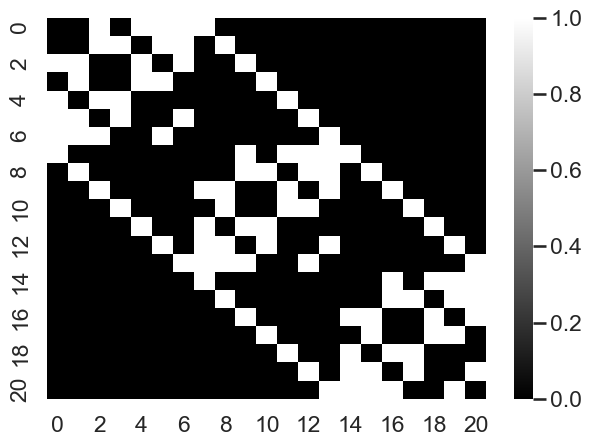

In [5]:
# Very straightforward calculation of adjacency from neighbouring voronoi cells
n_o = 7
n_b = 50
fg = FullGrid(f"cube4D_{n_b}", f"ico_{n_o}",
              "linspace(1, 5, 3)", use_saved=False)
voronoi_adjacency = fg.get_adjacency_of_position_grid().toarray()
sns.heatmap(voronoi_adjacency, cmap="gray")
plt.tight_layout()
plt.show()

In [6]:
# visual display with numbered Voronoi cells
fgp = FullGridPlot(fg)
ani = fgp.make_full_voronoi_plot(save=False, animate_rot=True, numbered=True)
show_anim_in_jupyter(ani)

### Using polytope neighbours/distances

Since distances are trivial, let's just focus on rotations (o_grid). Let us compare three methods:
- Voronoi neighbours (reference)
- polytope neighbours (obtained during the process of sub-division)
- k smallest distances (calculate cdistance matrix, count k elements with smallest distances as neighbours of the point; k depends on the polytope and is different for polytope levels 0 and >= 1)

-> k for level 0/>0 is 3/4 for cube3D and 5/6 for icosahedron

The first method is reliably correct, but not aplicable to higher dimensions. I want to compare the other two methods to the first one to see if they are reliable, since I could extend both of them to orientations.


#### Icosahedron

Number of points for perfect divisions:
- 12
- 42
- 162
- 642

For these, other methods should work perfectly.

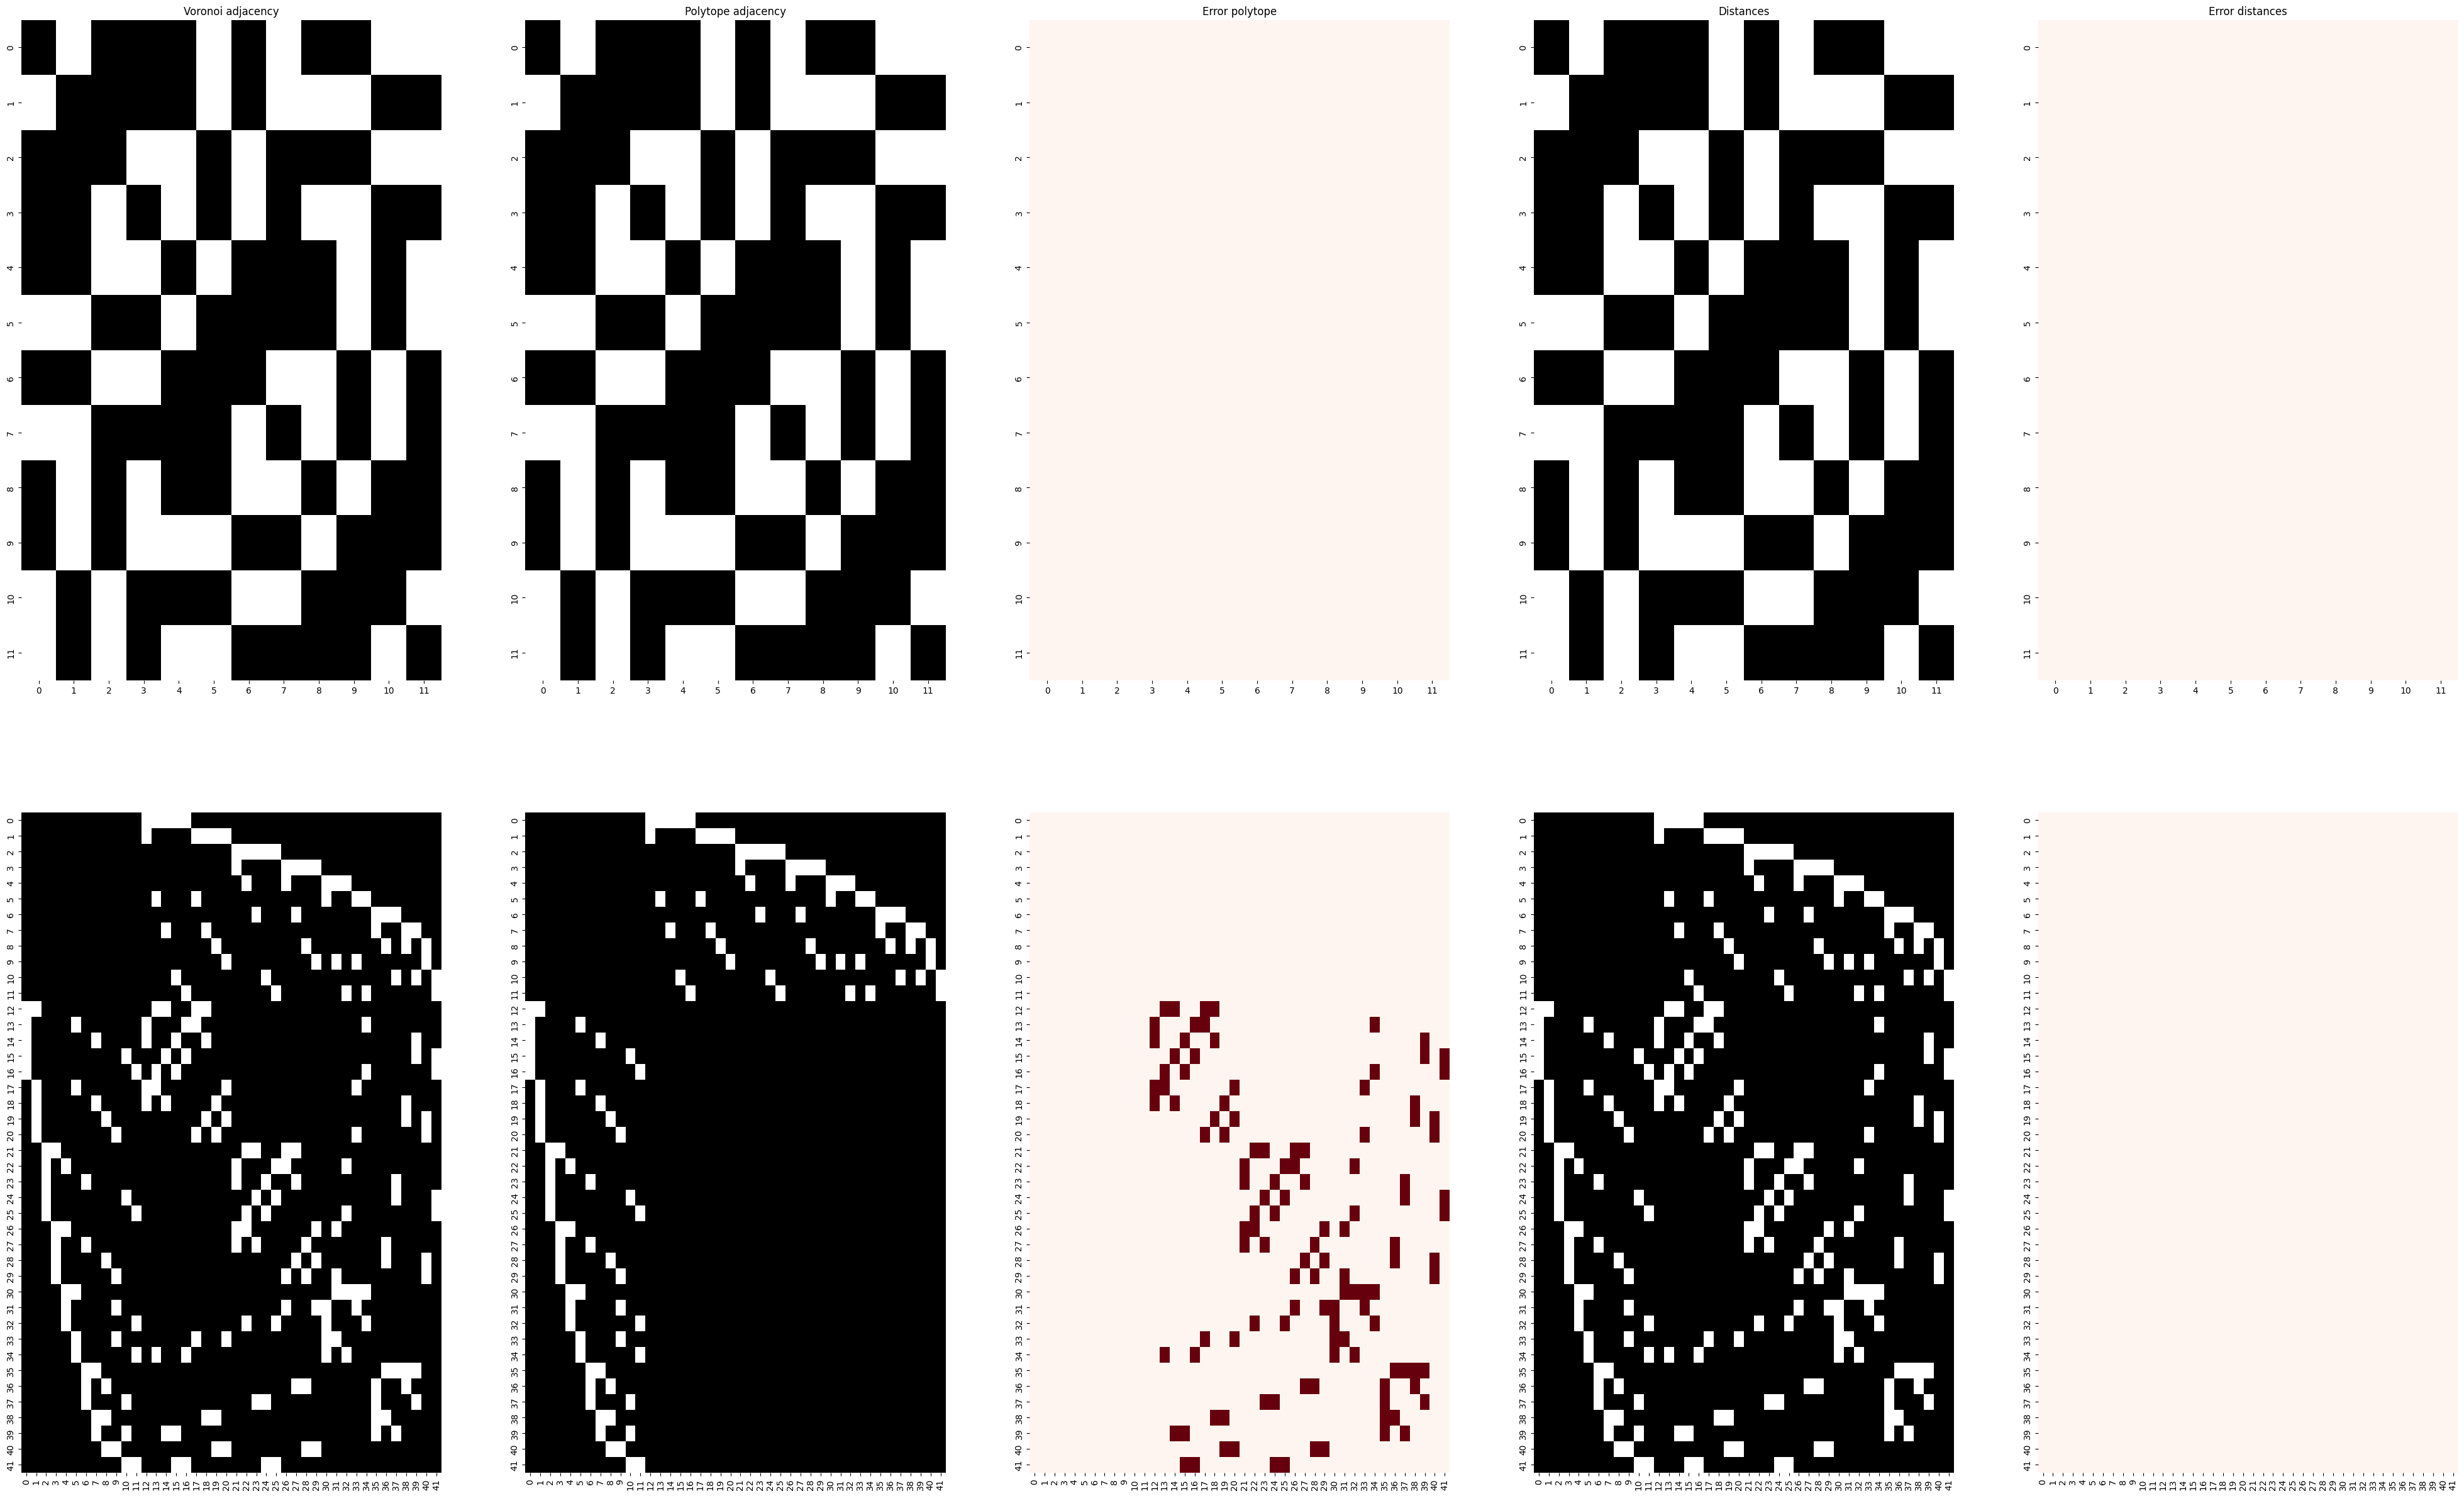

In [7]:
plt.close()
n_os = (12, 42) #, 162
fig, ax = plt.subplots(len(n_os), 5, figsize=(50, 30))

for i, n_o in enumerate(n_os):
    fg = FullGrid(f"zero", f"ico_{n_o}", "[0.1,]", use_saved=False)
    vor_adj = fg.get_adjacency_of_position_grid().toarray()
    sns.heatmap(vor_adj, cmap="gray", ax=ax[i][0], cbar=False)
    poly_adj = fg.get_polyhedron_adjacency(o_grid=True).toarray()
    sns.heatmap(poly_adj, cmap="gray", ax=ax[i][1], cbar=False)
    sns.heatmap(poly_adj^vor_adj, cmap="Reds", ax=ax[i][2], cbar=False)
    empty_arr = fg.get_poly_dist_adjacency()
    sns.heatmap(empty_arr, ax=ax[i][3], cmap="gray", cbar=False)
    sns.heatmap(empty_arr^vor_adj, ax=ax[i][4], cmap="Reds", cbar=False)
ax[0][0].set_title("Voronoi adjacency")
ax[0][1].set_title("Polytope adjacency")
ax[0][2].set_title("Error polytope")
ax[0][3].set_title("Distances")
ax[0][4].set_title("Error distances")
plt.show()

See below - polytope division of icosahedron actually misses some real neighbours.

In [8]:
# explain the red areas of poly_adj
n_o = 42
fg = FullGrid(f"zero", f"ico_{n_o}", "[0.1,]", use_saved=False)
colors = ["white"] * len(fg.get_flat_position_grid())
poly_adj = fg.get_polyhedron_adjacency(o_grid=True).toarray()
point_index = 41

for i, trug in enumerate(poly_adj[point_index]):
    if trug:
        colors[i] = "green"
colors[point_index] = "blue"

fgp = FullGridPlot(fg)
ani = fgp.make_full_voronoi_plot(save=False, animate_rot=True, numbered=True, colors=colors)
show_anim_in_jupyter(ani)

#### Cube 3D

Number of points for perfect divisions:
- 14
- 50
- 194
- 770

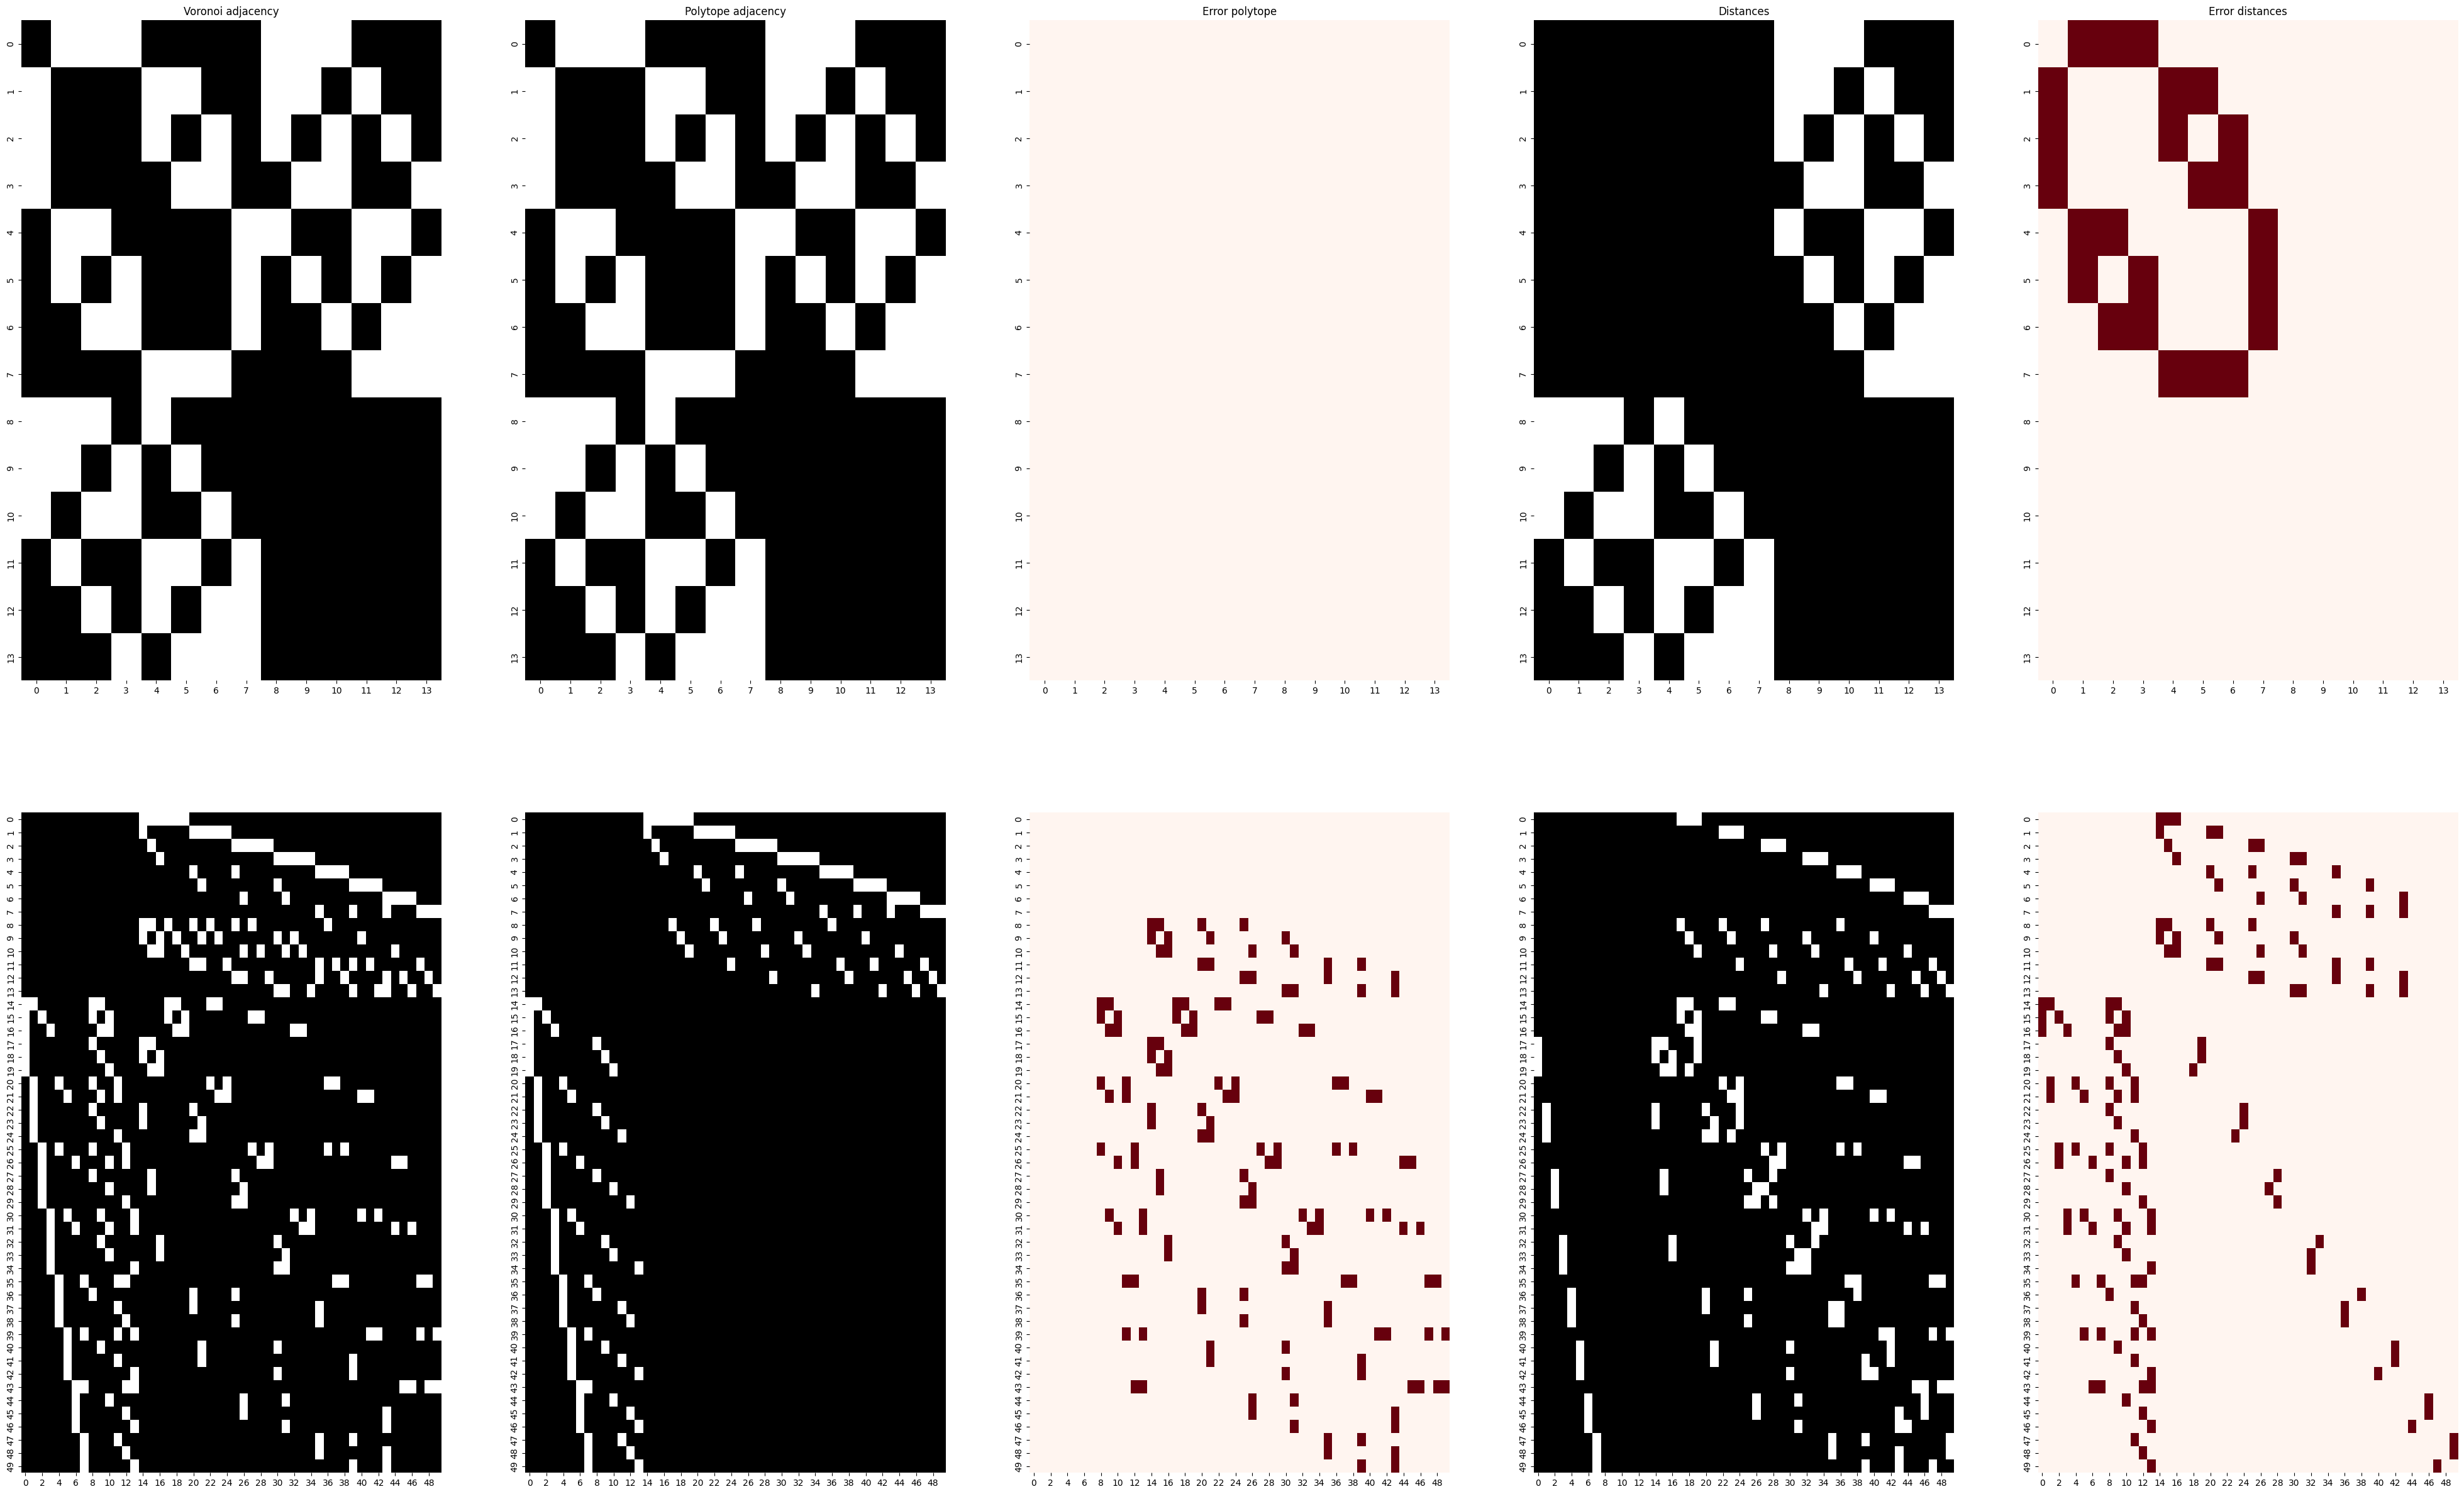

In [9]:
# repeat for cubes
plt.close()
n_os = (14, 50) #, 194
fig, ax = plt.subplots(len(n_os), 5, figsize=(50, 30))
for i, n_o in enumerate(n_os):
    fg = FullGrid(f"zero", f"cube3D_{n_o}", "[0.1,]", use_saved=False)
    vor_adj = fg.get_adjacency_of_position_grid().toarray()
    sns.heatmap(vor_adj, cmap="gray", ax=ax[i][0], cbar=False)
    poly_adj = fg.get_polyhedron_adjacency(o_grid=True).toarray()
    sns.heatmap(poly_adj, cmap="gray", ax=ax[i][1], cbar=False)
    sns.heatmap(poly_adj^vor_adj, cmap="Reds", ax=ax[i][2], cbar=False)
    empty_arr = fg.get_poly_dist_adjacency()
    sns.heatmap(empty_arr, ax=ax[i][3], cmap="gray", cbar=False)
    sns.heatmap(empty_arr^vor_adj, ax=ax[i][4], cmap="Reds", cbar=False)
ax[0][0].set_title("Voronoi adjacency")
ax[0][1].set_title("Polytope adjacency")
ax[0][2].set_title("Error polytope")
ax[0][3].set_title("Distances")
ax[0][4].set_title("Error distances")
plt.show()

It may look like the distance method is also not working great here, but if we look at the points, we see that it is actually a reasonable prediction (the question whether it is better to use the diagonals too is open).

In [36]:
# explain the red areas
n_o = 50
fg = FullGrid(f"zero", f"cube3D_{n_o}", "[0.1,]", use_saved=False)
colors = ["white"] * len(fg.get_flat_position_grid())
dist_adj = fg.get_poly_dist_adjacency()
point_index = 12

for i, trug in enumerate(dist_adj[point_index]):
    if trug:
        colors[i] = "green"
colors[point_index] = "blue"

fgp = FullGridPlot(fg)
ani = fgp.make_full_voronoi_plot(save=False, animate_rot=True, numbered=True, colors=colors)
show_anim_in_jupyter(ani)

Conclusion (so far): not really able to determine neighbours in any way but Voronoi except for perfect divisions. Let's forcus on perfect divisions for now.

## Adjacency in orientation grids

Based on what we've learned in position space, we can only be sure that we achieve correct adjacency (without being able to do hyperspherical Voronoi) if we use cube4D algorithm with full subdivision steps. That means we are only allowed to use
- 8,
- 40,
- 272 or
- 2080
orientations.
(This is for 0-3 divisions of hypercube after removing double coverage of quaternions).

We can create adjacency matrices:
- directly from neighbours during polytope division
- from distance matrix using a particular cut-off

Some problems to be aware of:
- when determining neighbours need to take into account that q and -q are the same orientation (should share neighbours)
- need a quaternion-apropriate metric to construct distance matrix

In [11]:
c4_zero = Cube4DPolytope()

c4_one = Cube4DPolytope()
c4_one.divide_edges()

c4_two = Cube4DPolytope()
c4_two.divide_edges()
c4_two.divide_edges()

c4_three = Cube4DPolytope()
c4_three.divide_edges()
c4_three.divide_edges()
c4_three.divide_edges()

all_c4 = [c4_zero, c4_one, c4_two, c4_three]

### Expected number of neighbours

In [12]:
# Based on polyhedron division, there is a specific number of neighbours expected for every level of division
# Formula: 4 neighbours for vertices of cells, 5 for points on edges of cells, 6 otherwise

for i, hypercube in enumerate(all_c4):
    # there will always be 16 vertices
    num_vertices = 16
    
    # On the zeroth level there are 0 points per edge, on 1st one, on 2nd 1+2=3, on 3rd 1+2+4=7, on Nth
    # sum_[i=0 ...N-1] 2^i -> this number is called nd here
    
    nd = 0
    for j in range(0, i):
        nd += 2**(j)
        
    # Edges are shared between 3 cells, 12 edges per cell, 8 cells in a hypercube
    num_edges = 8 * 12 // 3 * nd
    num_total_points = hypercube.G.number_of_nodes()
    
    # Using the formula & calculating average
    expected_num_of_neig = num_vertices * 4 +  num_edges * 5 + (num_total_points - num_edges - num_vertices) * 6
    expected_num_of_neig /= num_total_points
    
    num_without_DC = len(hypercube.select_half_of_hypercube())
    
    print(f"For {i} divisions, expect {num_total_points} points ({num_without_DC} without DC), average num of neighbours is {expected_num_of_neig}")

For 0 divisions, expect 16 points (8 without DC), average num of neighbours is 4.0
For 1 divisions, expect 80 points (40 without DC), average num of neighbours is 5.2
For 2 divisions, expect 544 points (272 without DC), average num of neighbours is 5.764705882352941
For 3 divisions, expect 4160 points (2080 without DC), average num of neighbours is 5.938461538461539


### Displaying hypercube and half-hypercube

Displaying hypercube:
- animation where the 4th dimension is time
- 8 plots for each of 8 cubic cells (like displaying 3D cube with 6 squares for each face)

Select half-hypercube:  select a list of all nodes (each node a 4-tuple) that have non-negative first coordinate. Among the nodes with first coordinate equal zero, select only the ones with non-negative second coordinate etc.


In [13]:
# display how half-cube selection works

selected_half = c4_one.select_half_of_hypercube()

for n, d in c4_one.G.nodes(data=True):
    p = d["projection"]
    print(f"Node {n} with projection {np.round(p, 3)} is in selection: {n in selected_half}")
print(f"In total {len(selected_half)}/{c4_one.G.number_of_nodes()} are selected.")

Node (-0.5, -0.5, -0.5, -0.5) with projection [-0.5 -0.5 -0.5 -0.5] is in selection: False
Node (-0.5, -0.5, -0.5, 0.5) with projection [-0.5 -0.5 -0.5  0.5] is in selection: False
Node (-0.5, -0.5, 0.5, -0.5) with projection [-0.5 -0.5  0.5 -0.5] is in selection: False
Node (-0.5, -0.5, 0.5, 0.5) with projection [-0.5 -0.5  0.5  0.5] is in selection: False
Node (-0.5, 0.5, -0.5, -0.5) with projection [-0.5  0.5 -0.5 -0.5] is in selection: False
Node (-0.5, 0.5, -0.5, 0.5) with projection [-0.5  0.5 -0.5  0.5] is in selection: False
Node (-0.5, 0.5, 0.5, -0.5) with projection [-0.5  0.5  0.5 -0.5] is in selection: False
Node (-0.5, 0.5, 0.5, 0.5) with projection [-0.5  0.5  0.5  0.5] is in selection: False
Node (0.5, -0.5, -0.5, -0.5) with projection [ 0.5 -0.5 -0.5 -0.5] is in selection: True
Node (0.5, -0.5, -0.5, 0.5) with projection [ 0.5 -0.5 -0.5  0.5] is in selection: True
Node (0.5, -0.5, 0.5, -0.5) with projection [ 0.5 -0.5  0.5 -0.5] is in selection: True
Node (0.5, -0.5, 0.

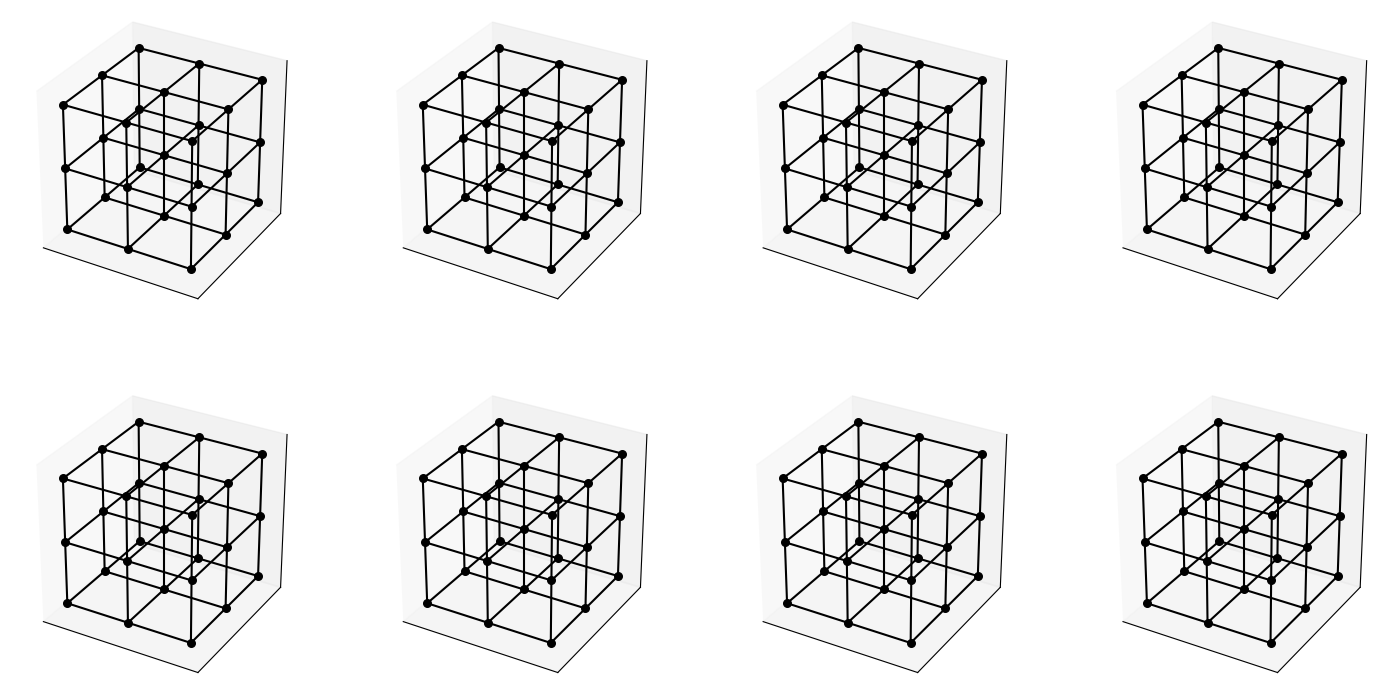

In [14]:
# this is full hypercube
ecp = EightCellsPlot(c4_one, only_half_of_cube=False)
ecp.plot_eight_cells(save=False)
plt.show()

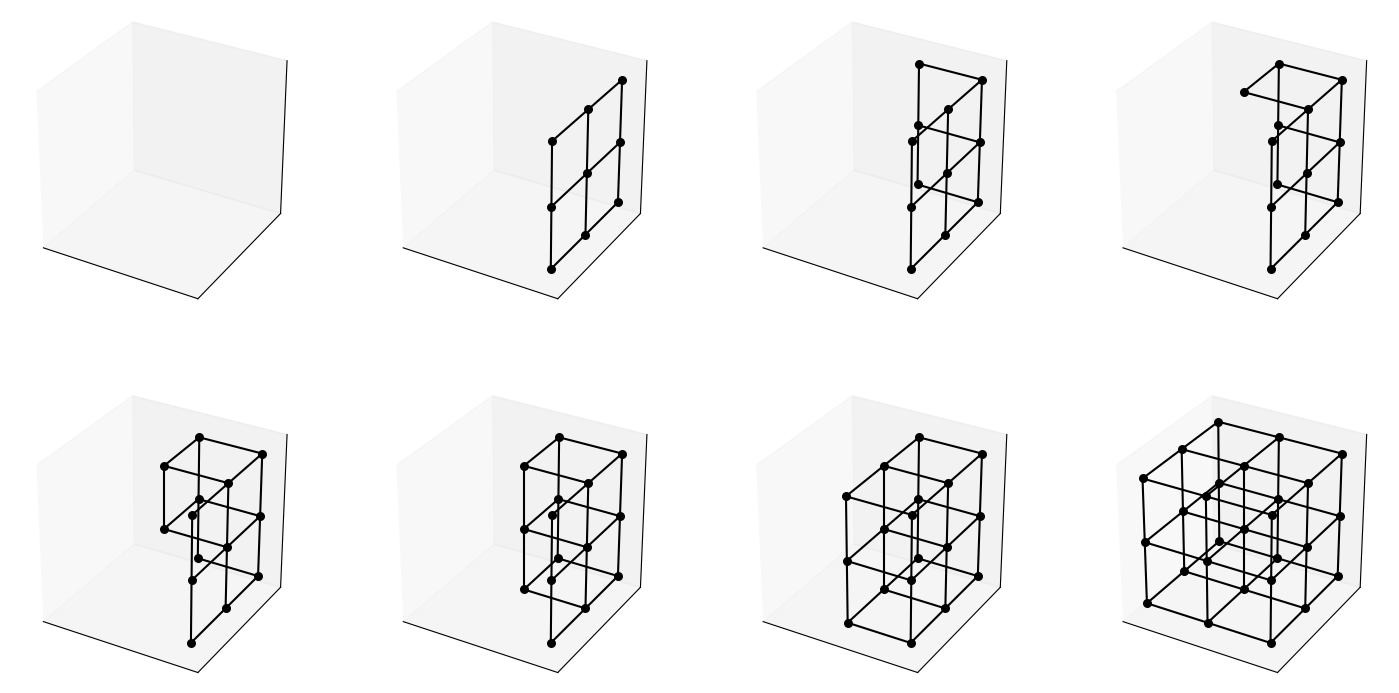

In [15]:
# this is hypercube without double-coverage
ecp_half = EightCellsPlot(c4_one, only_half_of_cube=True)
ecp_half.plot_eight_cells(save=False)
plt.show()

In [16]:
from molgri.plotting.spheregrid_plots import ArrayPlot


all_projected_points = np.array([d["projection"] for n, d in c4_two.G.nodes(data=True)])

ap = ArrayPlot(data_name="full_hypercube", my_array=all_projected_points)
ani = ap.make_trans_animation()
show_anim_in_jupyter(ani)

In [17]:
selected_half = c4_two.select_half_of_hypercube()
half_projected_points = np.array([d["projection"] for n, d in c4_two.G.nodes(data=True) if n in selected_half])

ap = ArrayPlot(data_name="half_hypercube", my_array=half_projected_points)
ani = ap.make_trans_animation()
show_anim_in_jupyter(ani)

### Displaying neighbourship in hypercube

A polytope is created with subdivision of neighbouring points. Let us display the neighbours of a particular point.


#### All nodes, no opposing neighbours

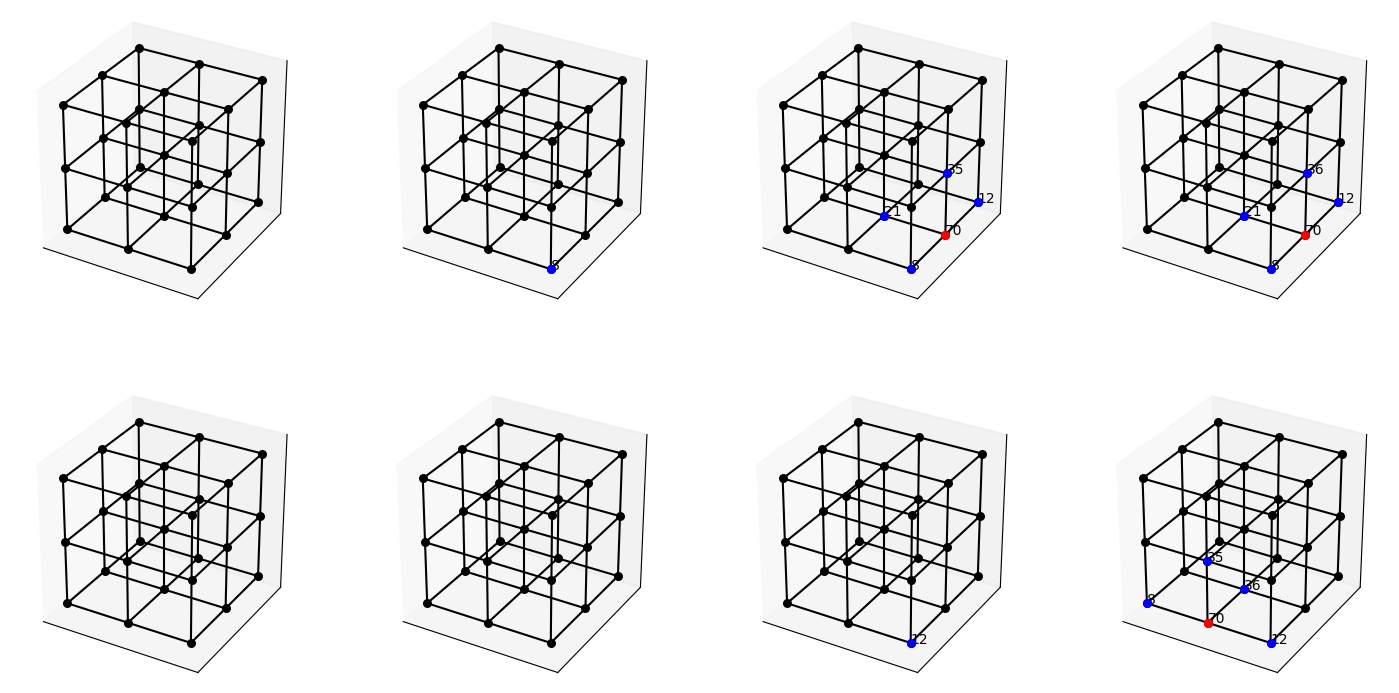

In [18]:
# 0 is on vertex, has 4 neighbours
# 70 is on edge, has 5 neighbours
# 21 on a face, has 6 neighbours
# 40 is inside, has 6 neighbours

ecp = EightCellsPlot(c4_one, only_half_of_cube=False)
ecp.plot_polytope_neighbours(70, animate_rot=False, include_opposing_neighbours=False, save=False)
plt.show()

Based on this neighbourship we can create adjacency matrix (white=neighbour). We also calculate the average number of neighbours per point (av number of white cells per line in adjacency matrix).

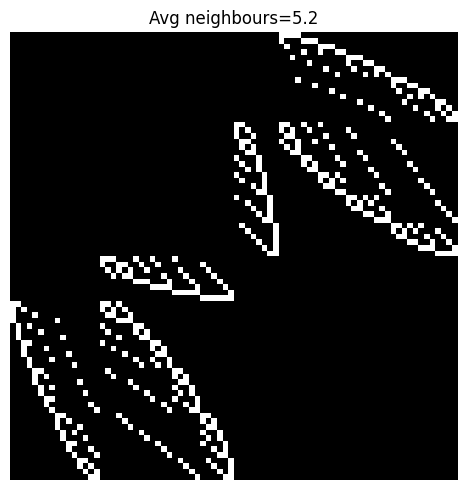

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ecp.plot_adj_matrix(include_opposing_neighbours=False, save=False, fig=fig, ax=ax)
plt.show()

Of course we are actually only interested in half of the hypercube, otherwise each orientation is represented twice.

#### Half nodes, no opposing neighbours

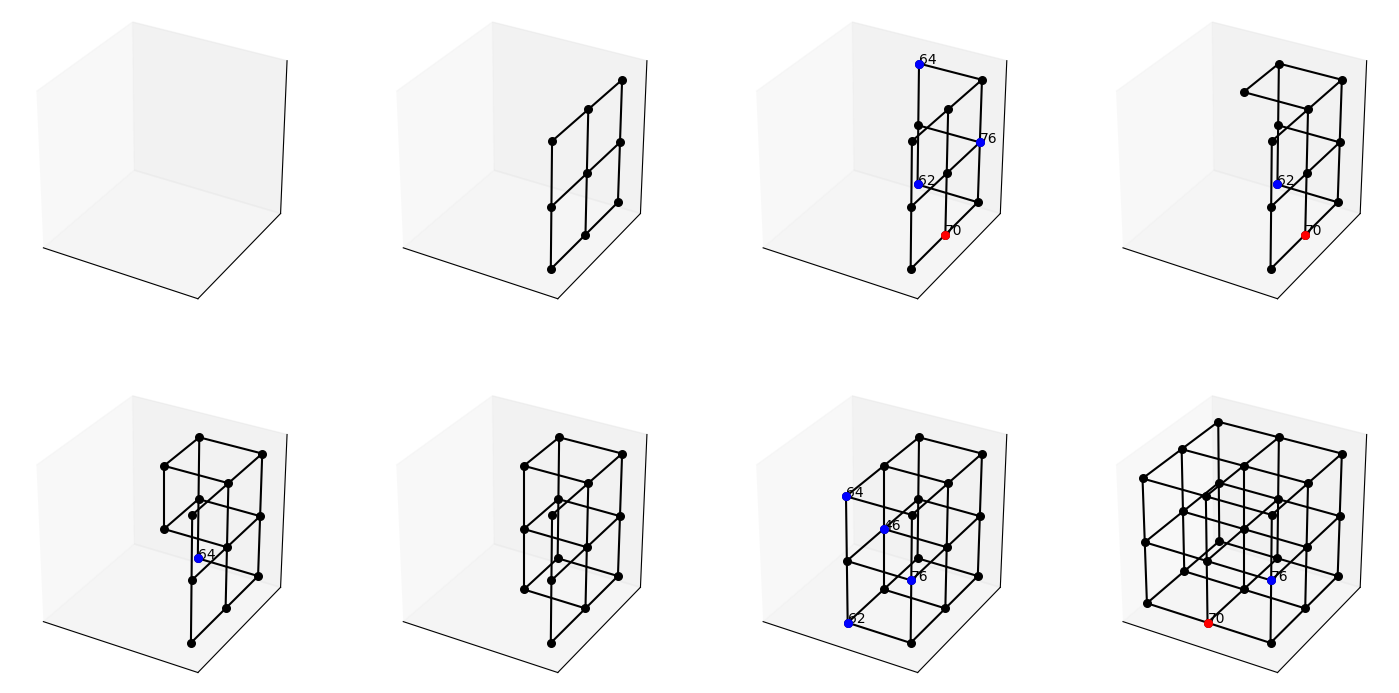

In [20]:
ecp_half = EightCellsPlot(c4_one, only_half_of_cube=True)
ecp_half.plot_polytope_neighbours(70, animate_rot=False, include_opposing_neighbours=False, save=False)
plt.show()

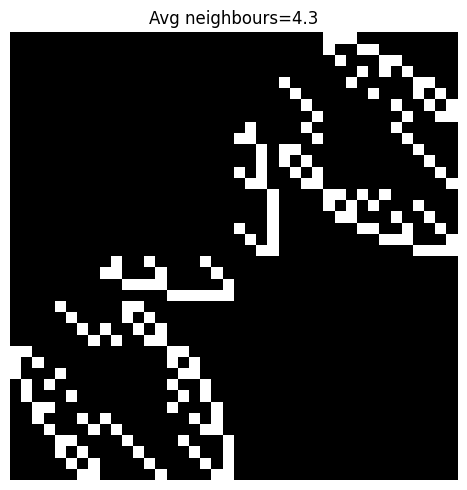

In [21]:
ecp_half.plot_adj_matrix(include_opposing_neighbours=False, save=False)
plt.show()

Now the issue is ... if we only use half of the cube, the number of neighbours falls below the expected level. Why is that? Well, when we simply remove half of the points, some remaining points lose neighbours, which shouldn't actually happen, since we are actually removing duplicates ... the reason is that we were counting neighbours wrongly from the beginning. In addition to direct neighbours, we must consider the neighbours of the opposing point too.

#### All nodes, including opposing neighbours

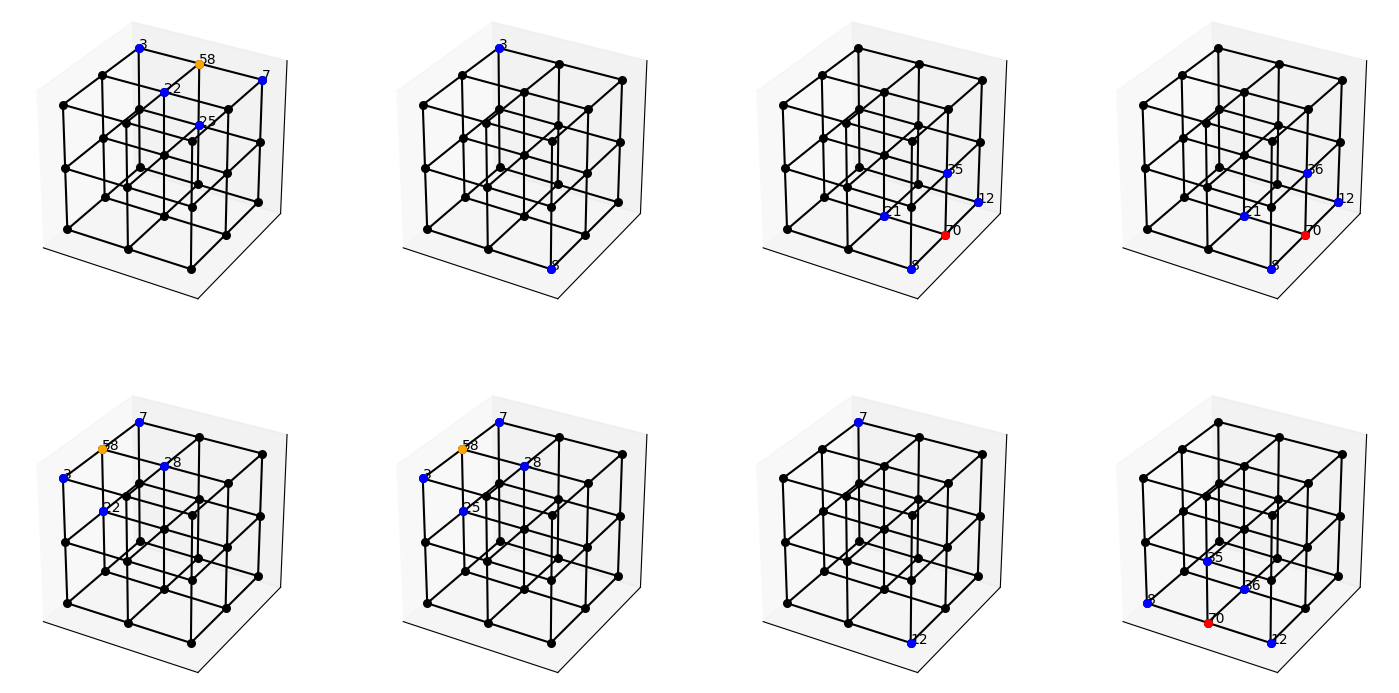

In [22]:
# the opposing node is shown in orange. Either the red or the orange point will be removed when selecting half-cube

ecp = EightCellsPlot(c4_one, only_half_of_cube=False)
ecp.plot_polytope_neighbours(70, animate_rot=False, include_opposing_neighbours=True, save=False)
plt.show()

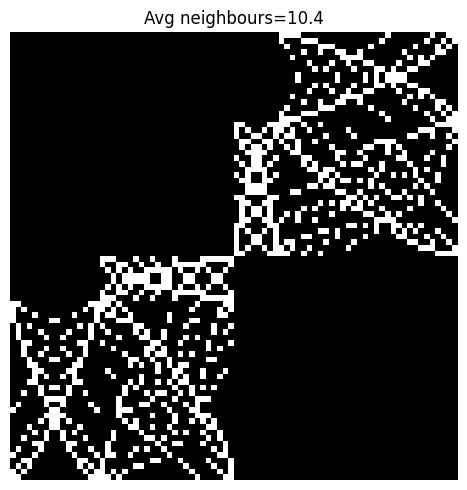

In [23]:
ecp.plot_adj_matrix(include_opposing_neighbours=True, save=False)
plt.show()

With this we finally come to the correct constellation

#### Half nodes, including opposing neighbours

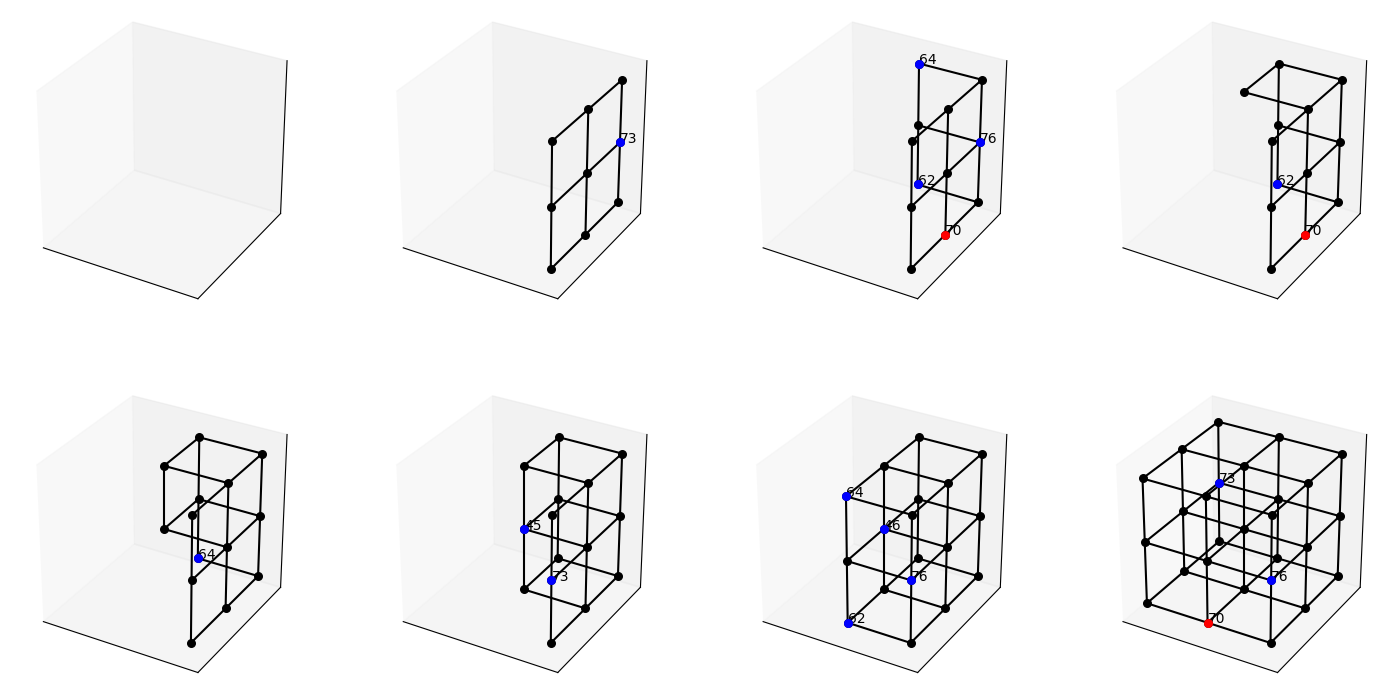

In [24]:
ecp_half = EightCellsPlot(c4_one, only_half_of_cube=True)
ecp_half.plot_polytope_neighbours(70, animate_rot=False, include_opposing_neighbours=True, save=False)
plt.show()

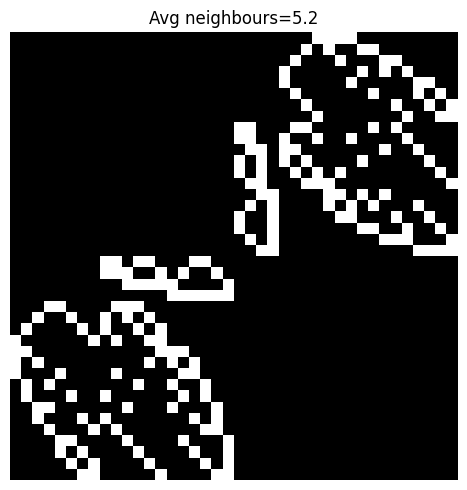

In [25]:
ecp_half.plot_adj_matrix(include_opposing_neighbours=True, save=False)
plt.show()

### Compare with distance matrix

As a test, we expect points that are adjacent to also be close together. Using appropriate measure, we can calculate the matrix of distances between all points (or again, only half the points) and compare this matrix to the adjacency matrix we just created.

The measure for distances is:

```
def constrained_angle_distance(q1, q2):
    theta = angle_between_vectors(q1, q2)
    if (theta > pi / 2):
        theta = pi - theta
    return theta
```

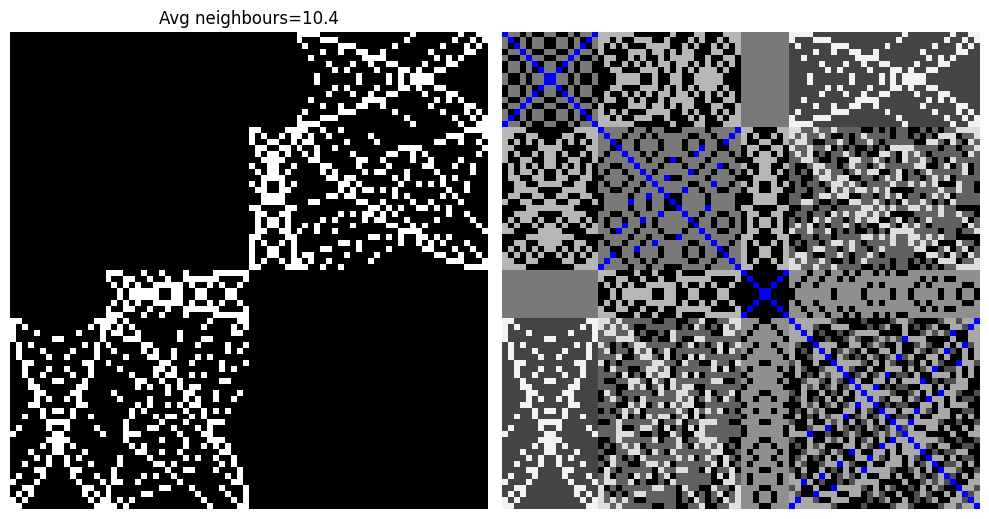

In [26]:
# full cubes, blue = value zero
fig, ax = plt.subplots(1, 2, figsize=(10,20))
ecp.plot_adj_matrix(include_opposing_neighbours=True, save=False, fig=fig, ax=ax[0])
ecp.plot_cdist_matrix(ax=ax[1], fig=fig, save=False)
plt.show()

Note how we have two blue values per row. Note also that the white patterns left and right repeat. It will be even more visible when we remove repeating points.

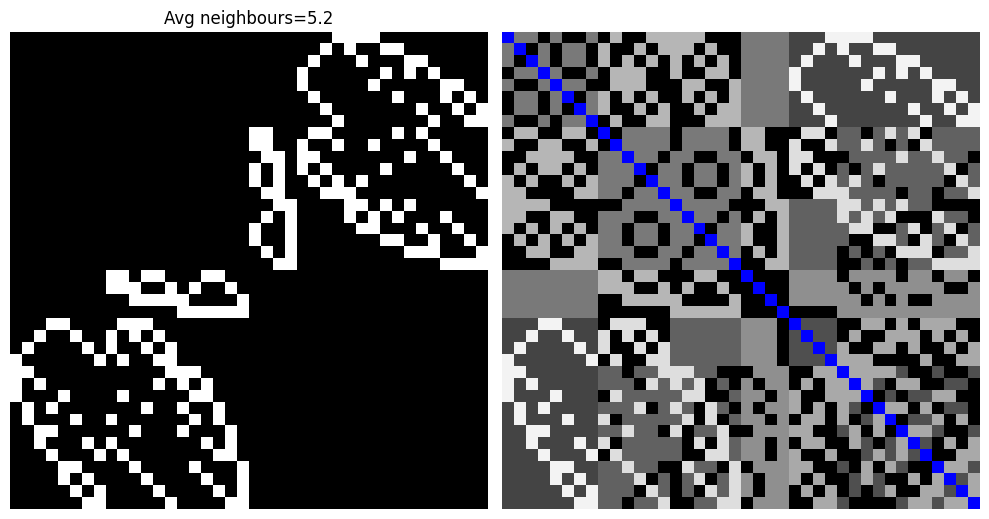

In [27]:
# half cubes, blue = value zero
fig, ax = plt.subplots(1, 2, figsize=(10,20))
ecp_half.plot_adj_matrix(include_opposing_neighbours=True, save=False, fig=fig, ax=ax[0])
ecp_half.plot_cdist_matrix(ax=ax[1], fig=fig, save=False)
plt.show()

Notice how the patterns above were symmetrized versions of these ones?

This mostly looks really good. The adjacent points equal the "whitest" points in cdist matrix - the points with smallest distances. However, some grayish points are hard to order. To get a closer look, we decompose the cdist matrix and look at what causes particular patterns.

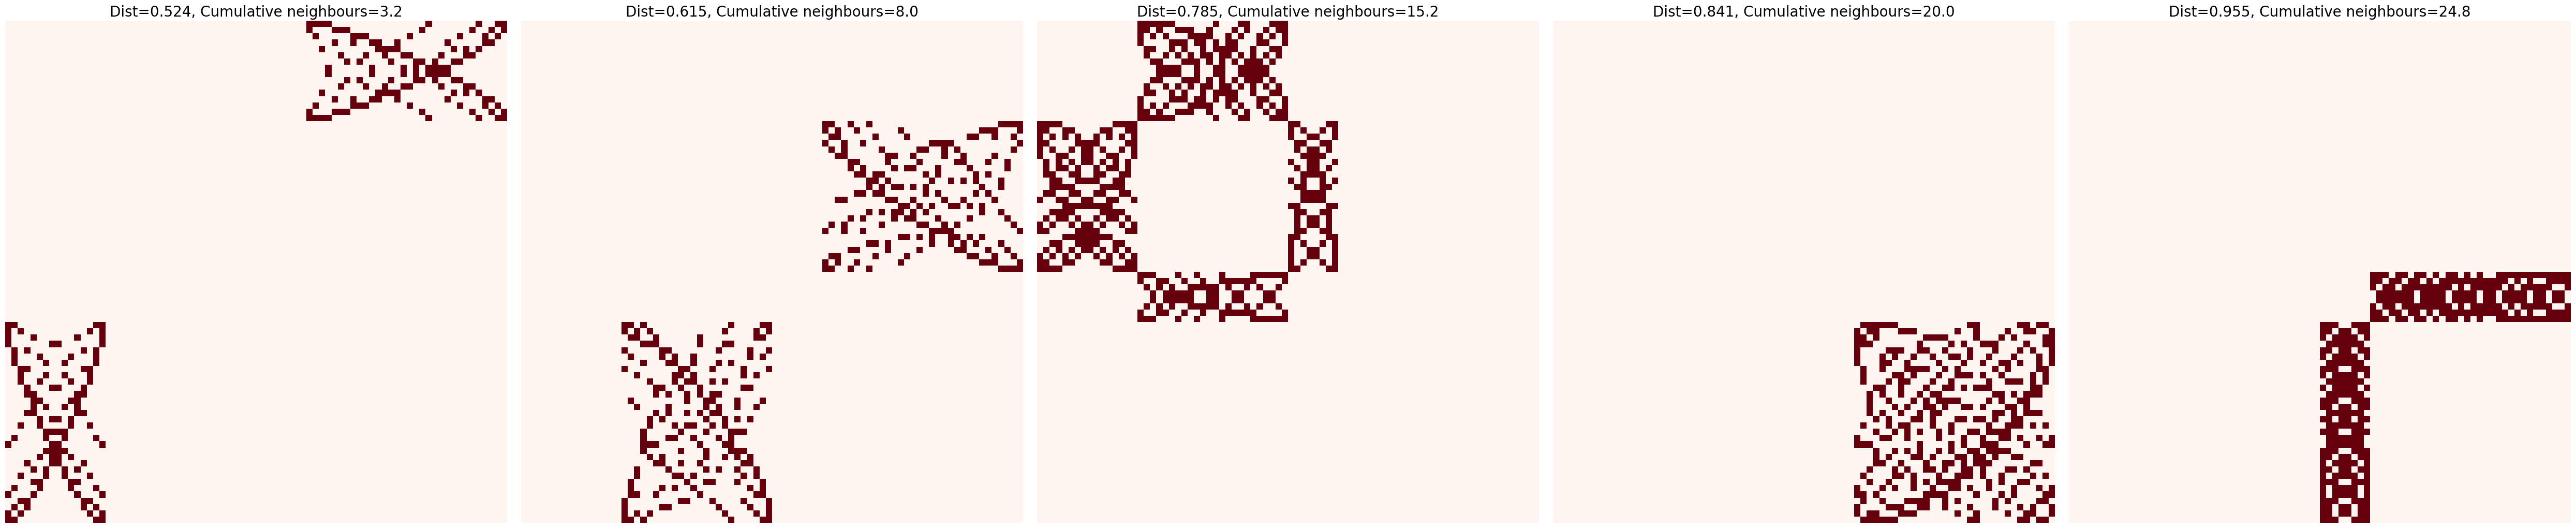

In [28]:
decompositions = ecp.decompose_cdist(save=False, vmax=1)
plt.show()

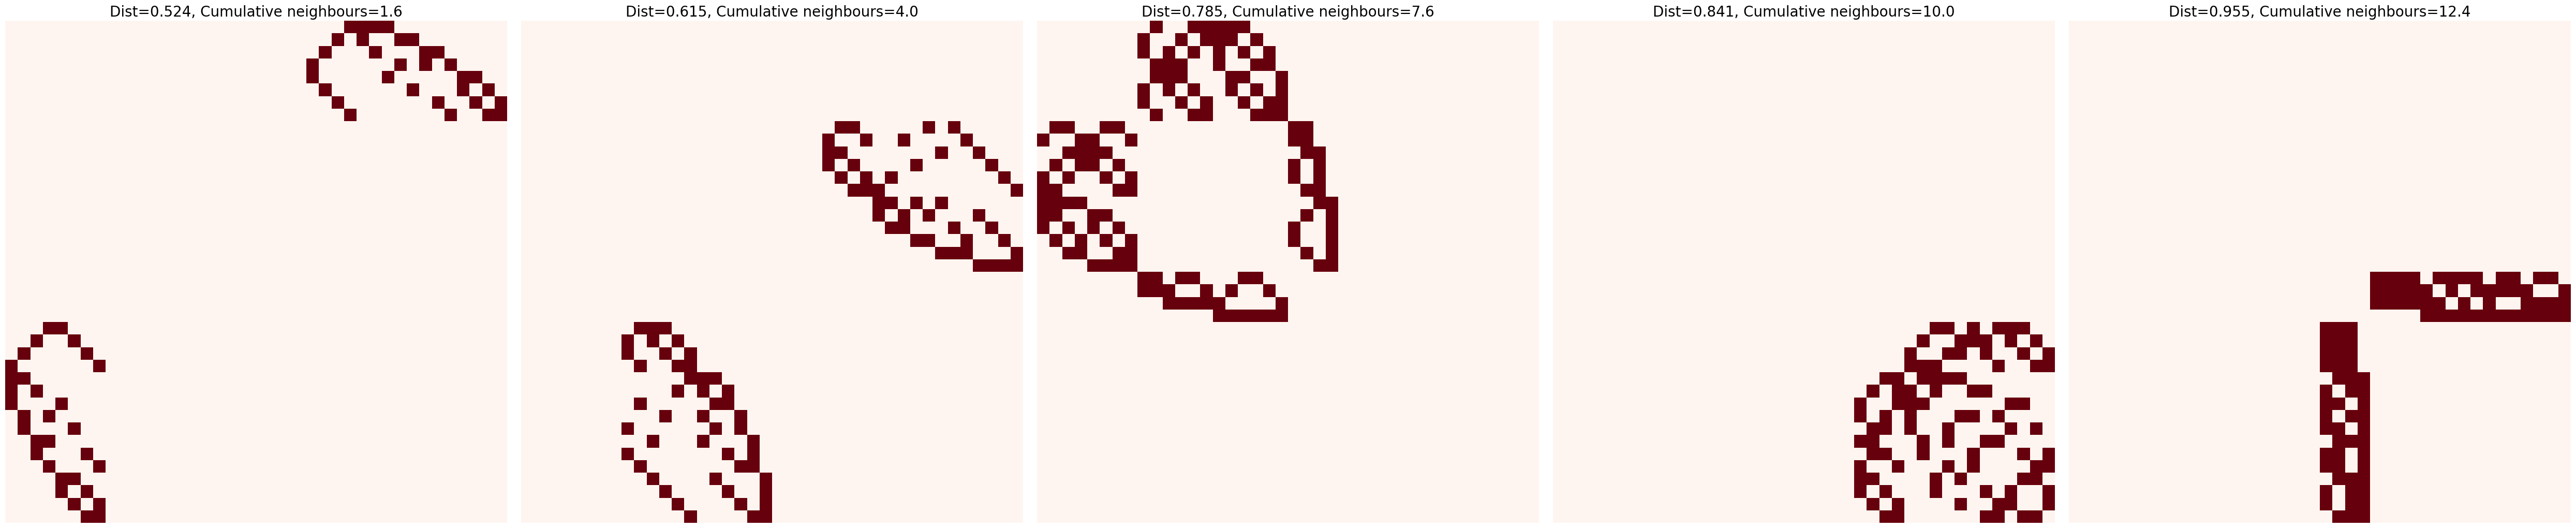

In [29]:
decompositions_half = ecp_half.decompose_cdist(save=False, vmax=1)
plt.show()

Now the category 0 and 1 of decomposition are also present in the adjacency matrix, so it's clear - those are the shortest distances and also neighbours, as expected. Category 2 is a bit weird - it includes all the rest of adjacency points, but also some other extra points. what is happening there? Let us visualise which kinds of points belong to category 2.

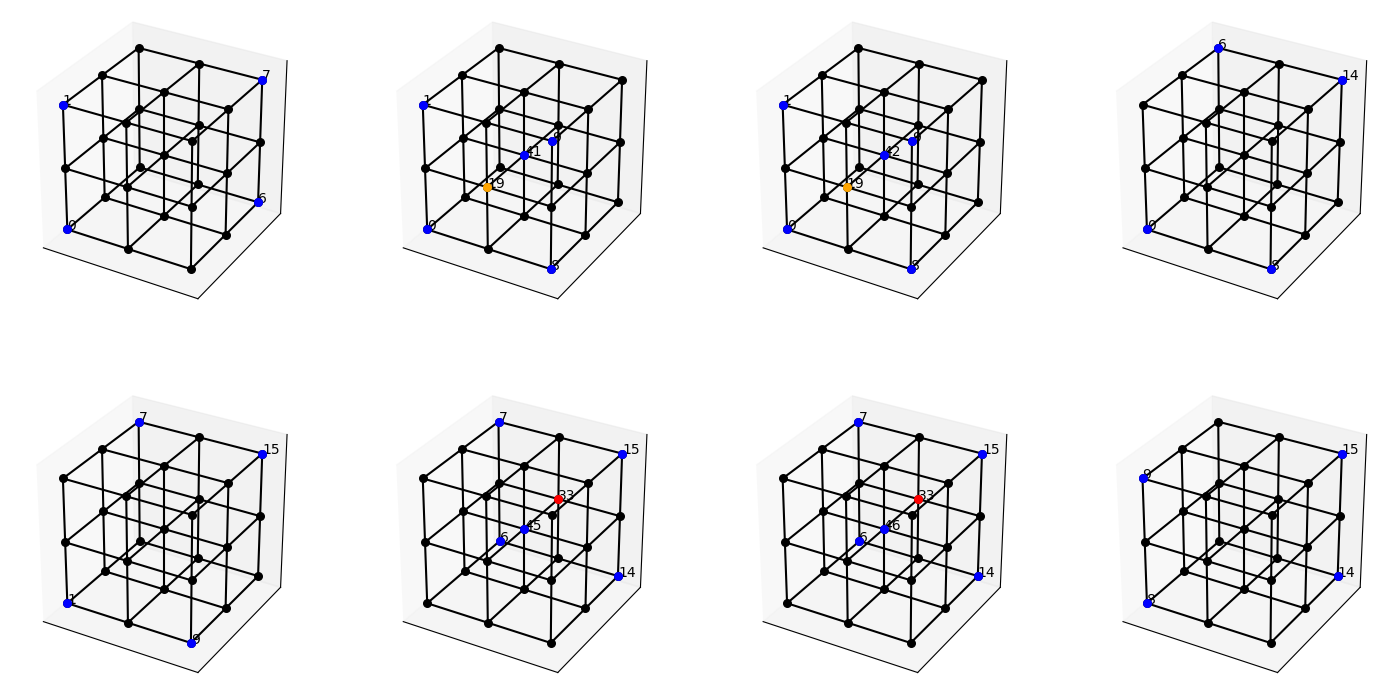

In [30]:
# let's figure out which points are in this specific matrices

# 15 is on vertex, has 4 neighbours
# all of 15's direct neighbours are in category 0 (0.524) + diagonal neighbours in category 2 (0.785)


# 70 is on edge, has 5 neighbours
# 70 has vertex neighbours in category 0, other direct neighbours in category 1 (0.615), no neighbours in cat 2


# 33 on a face, has 6 neighbours
# 33 has no neighbours in category 0, 4 direct in category 1, 2 direct + 4 diagonal ones in category 2


# 45 is inside, has 6 neighbours
# 45 has no neighbours in category 0 or 1, 6 direct ones in category 2


first_index = 33
opposing_index = find_opposing_q(first_index, c4_one.G)


second_indices = list(np.where(decompositions[2][first_index] == True)[0])


ecp.plot_eight_cells(save=False)
ecp._plot_in_color([first_index,], color="red", all_ax=ecp.all_ax, fig=ecp.fig)
ecp._plot_in_color(second_indices, color="blue", all_ax=ecp.all_ax, fig=ecp.fig)
ecp._plot_in_color([opposing_index,], color="orange", all_ax=ecp.all_ax, fig=ecp.fig)
plt.show()

CONCLUSION: category 2 is confusing because in addition to direct neighbours of inside elements, it also includes some diagonal elements that are particularly close.

Hypercube, like cube, distorts a bit. The points near vertices are closer together than points far from vertices (here: middle of cell). However, the number of neighbours doesn't directly depend on distances; I belive we can safely use the polytope adjacency matrix. If there are problems, we can reconsider if we still need to use the entire category 2 to describe neighbouring relations

### Conclusion

To the best of my knowledge, these are the correct adjacency matrices

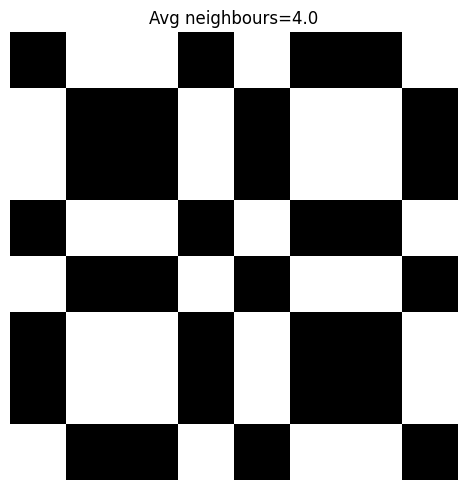

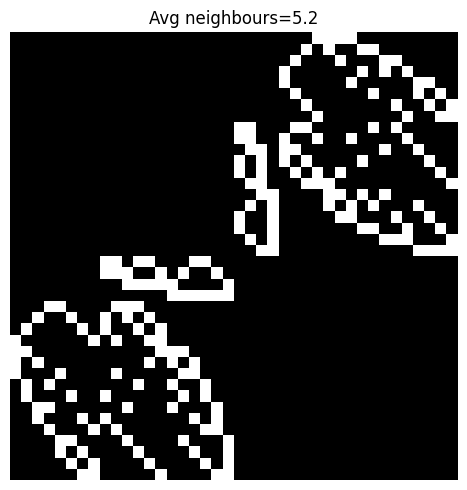

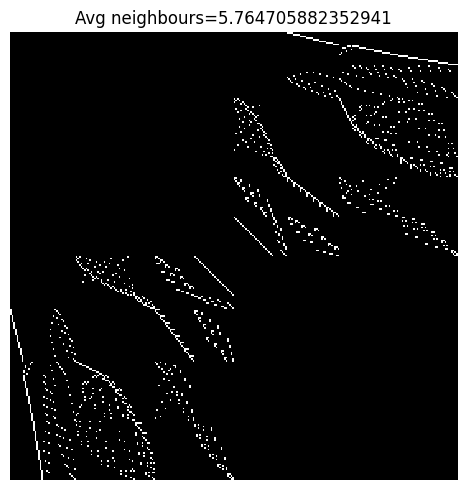

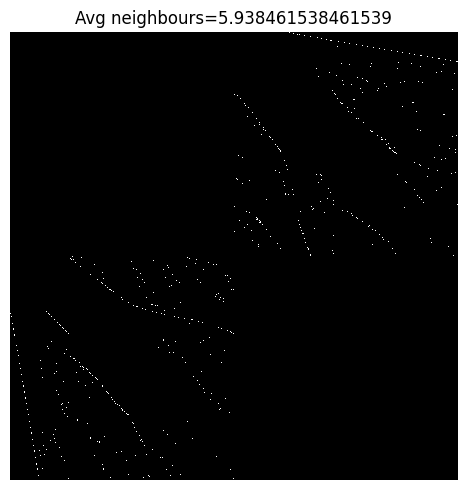

In [31]:
for c4 in all_c4:
    ecp_half = EightCellsPlot(c4, only_half_of_cube=True)
    ecp_half.plot_adj_matrix(include_opposing_neighbours=True, save=False)
    plt.show()

Hm, why actually those giant black squares?

Well, how are the points numbered?  

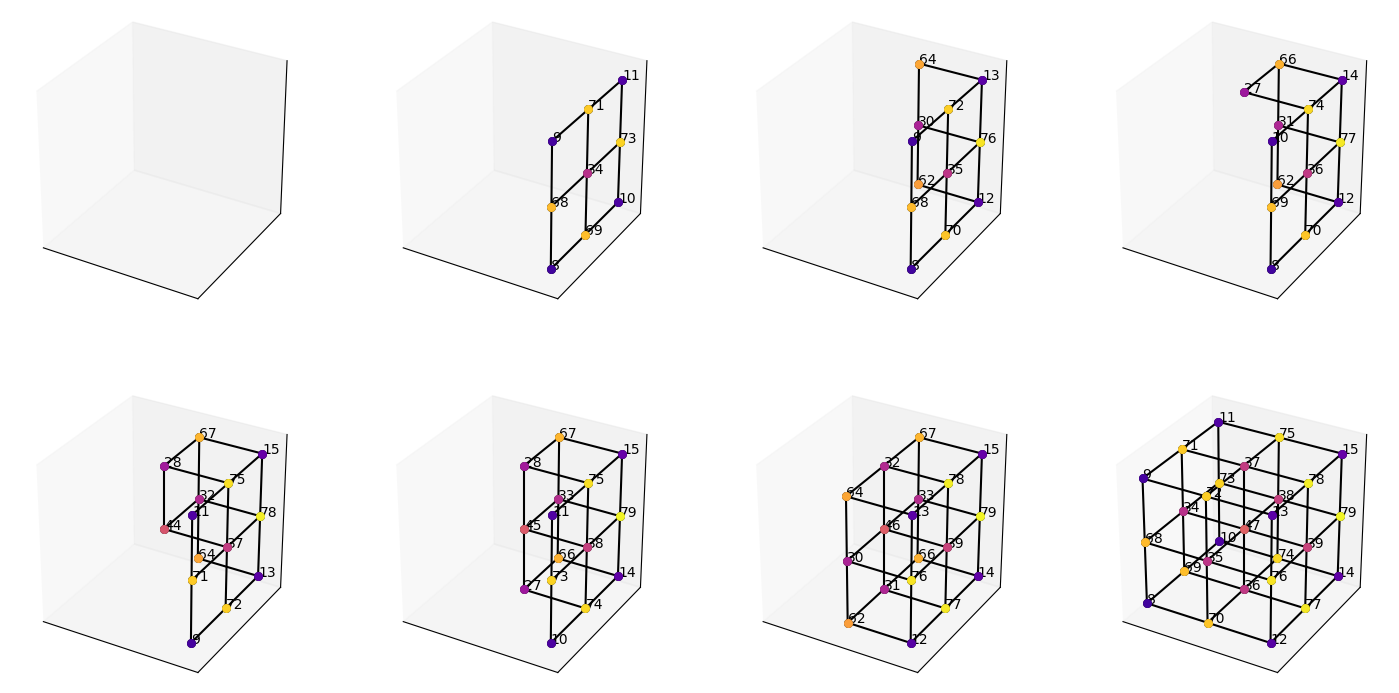

In [32]:
plt.close()

c4 = Cube4DPolytope()
c4.divide_edges()
#c4.divide_edges()

ecp = EightCellsPlot(c4, only_half_of_cube=True)
num_points = c4.G.number_of_nodes() #//2

p = plt.get_cmap('plasma')

ecp.plot_eight_cells(save=False)


for node_i in range(num_points): 
    ecp._plot_in_color([node_i,], color=p(node_i/num_points), all_ax=ecp.all_ax, fig=ecp.fig)
plt.show()

Because of numbering conventions, there is a "layer" of new nodes (bright colors) in between "layers" of old nodes (dark colors). The neighbours of old nodes are thus exclusively new nodes and vice versa - adjacency matrix is empty in two of the four quadrants.

In [33]:
size_previous = 0
for i, c4 in enumerate(all_c4):
    adj_matrix = c4.get_polytope_adj_matrix(include_opposing_neighbours=True, only_half_of_cube=True)
    size_previous = len(adj_matrix)

Note: there are methods to reliably determine neighbouring relations of quaternions/orientations, see

**Yershova, Anna, and Steven M. LaValle. "Improving motion-planning algorithms by efficient nearest-neighbor searching." IEEE Transactions on Robotics 23.1 (2007): 151-157.**

if volume/surface/distance calculations work for the limited set of cases introduced now (full divisions), I would return to adjacency problem in general case.

## Test: Try to do translation animation again

## Test: plot object in initial and adjacent orientations

Repeat the same plot using distances between quaternions

## Combined Adjacency

Points are adjacent if same point on position grid and neighbours on orientation grid; OR neighbours on position gris and same point on orientation grid.

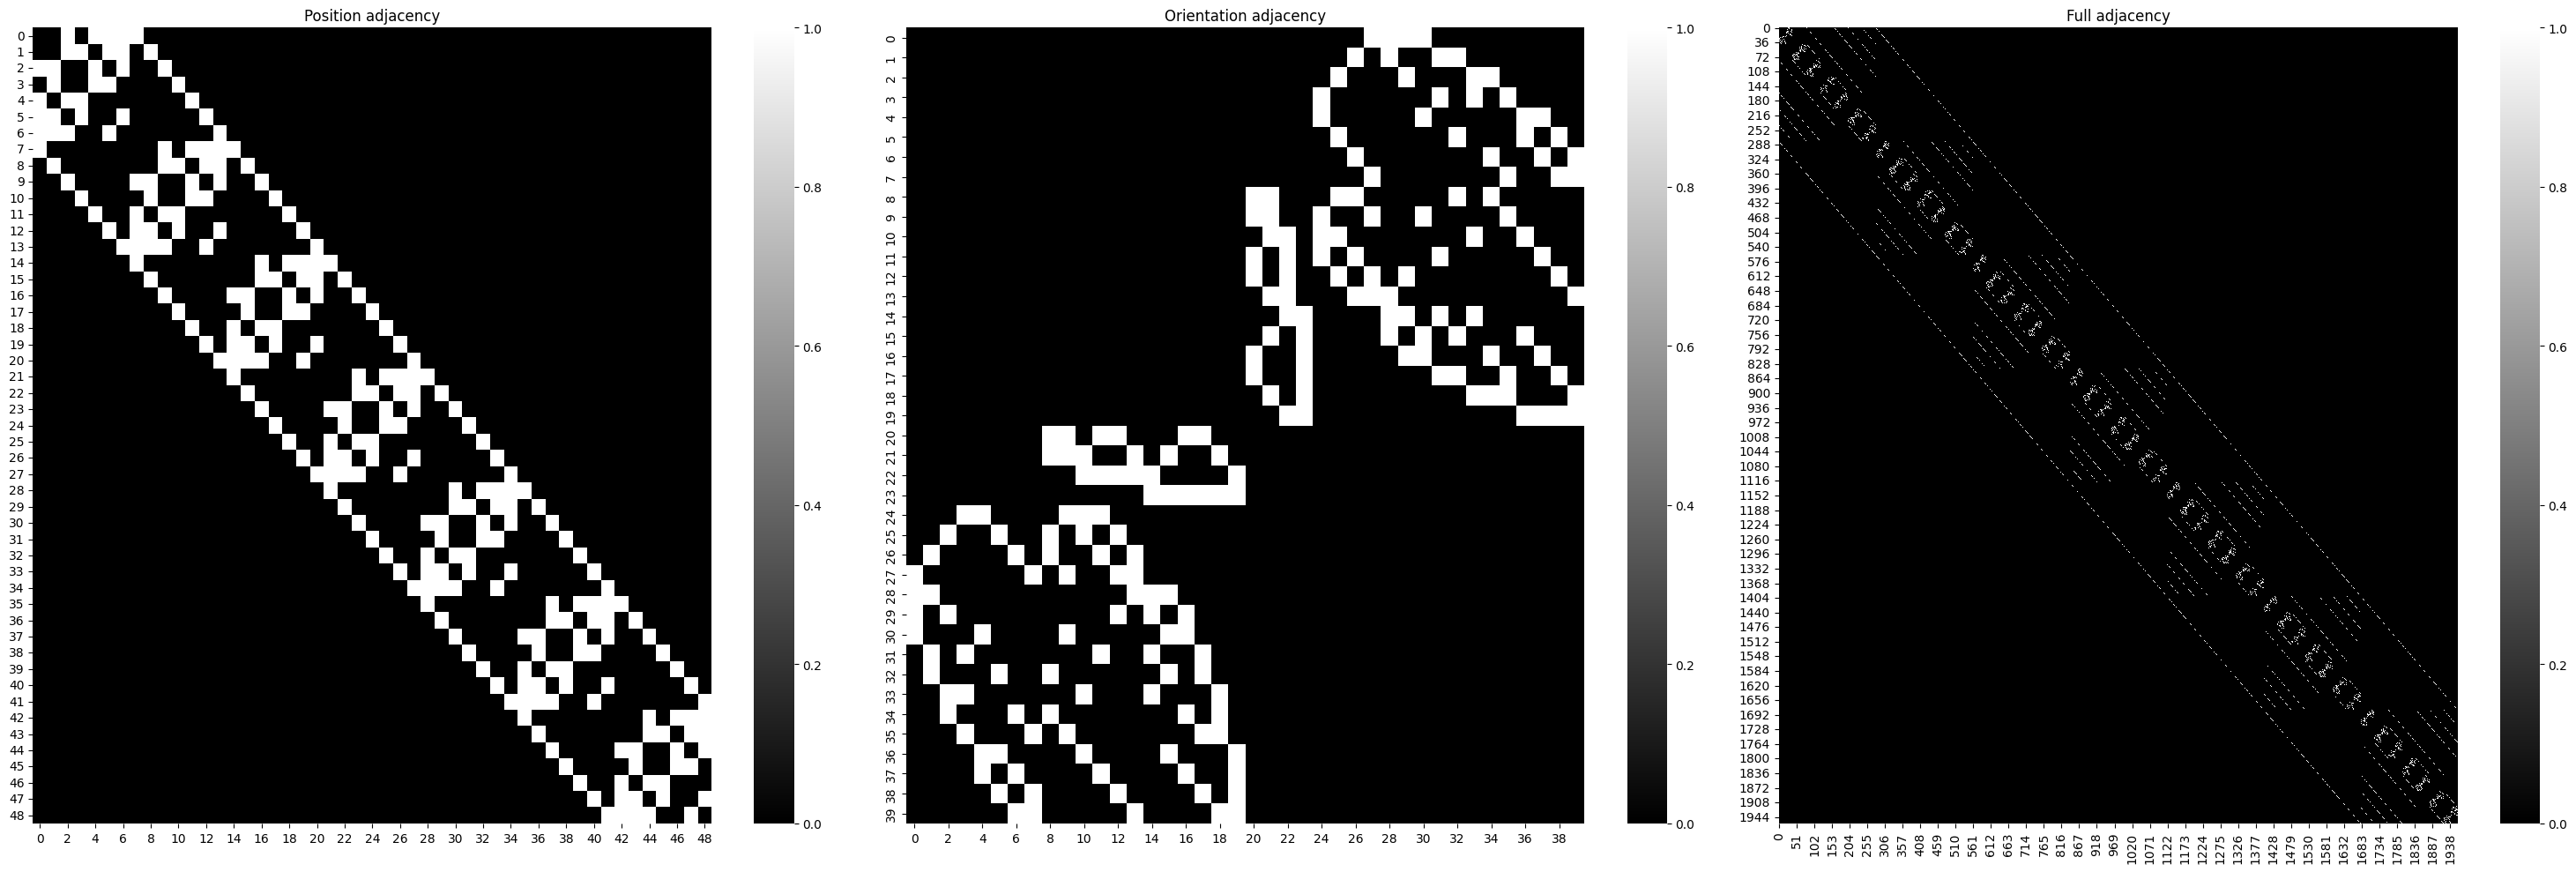

In [34]:
n_o = 7
n_b = 40
fg = FullGrid(f"fulldiv_{n_b}", f"ico_{n_o}", "linspace(1, 5, 7)", use_saved=False)

position_adjacency = fg.get_adjacency_of_position_grid().toarray()
orientation_adjacency = fg.get_adjacency_of_orientation_grid()

fig, ax = plt.subplots(1, 3, figsize=(30, 10))
sns.heatmap(position_adjacency, cmap="gray", ax=ax[0])
sns.heatmap(orientation_adjacency, cmap="gray", ax=ax[1])
sns.heatmap(fg.get_full_adjacency().toarray(), cmap="gray", ax=ax[2])
ax[0].set_title("Position adjacency")
ax[1].set_title("Orientation adjacency")
ax[2].set_title("Full adjacency")
plt.tight_layout()
plt.show()

In [35]:
# check some points from full adjacency matrix to show they really are/aren't neighbours
sequence = fg.get_full_sequence()